## Demo Kmean cho khoá luận tốt nghiệp

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pathlib import Path

In [3]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns


### Tạo dữ liệu mẫu

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path

# ---------------------- Hàm sinh dữ liệu ----------------------
def prepare_data_smart(n_samples: int = 5_000, random_state: int | None = None):
    """
    Sinh dữ liệu hành vi học tập mô phỏng có tương quan logic.
    Trả về:
      • df  : DataFrame đầy đủ (gồm cột quiz_score)
      • X   : ndarray chỉ chứa feature (dùng cho ML, bỏ cột quiz_score)
    """
    rng = np.random.default_rng(random_state)

    engagement = rng.beta(a=2, b=5, size=n_samples)

    video_views = np.clip(rng.poisson(lam=engagement * 10), 0, 15)
    quiz_done_theory = np.clip(rng.poisson(lam=engagement * 8), 0, 10)
    quiz_done_application = np.clip(
        rng.binomial(n=quiz_done_theory, p=0.5), 0, None
    )
    pdf_views = np.clip(
        rng.poisson(lam=video_views * rng.uniform(0.2, 0.6, n_samples)), 0, 10
    )

    chapter = rng.choice([1, 2, 3, 4, 5, 6], size=n_samples,
                         p=[0.25, 0.20, 0.18, 0.15, 0.12, 0.10])
    chapter = np.clip(chapter + (engagement * 2).astype(int), 1, 6)

    noise = rng.normal(0, 1.2, n_samples)
    quiz_score_raw = (
        0.6 * (quiz_done_theory + quiz_done_application)
        + 0.2 * video_views
        + noise
    )
    quiz_score = np.round(np.clip(quiz_score_raw / 2, 0, 10)).astype(int)

    df = pd.DataFrame({
        "video_views": video_views,
        "quiz_done_theory": quiz_done_theory,
        "quiz_done_application": quiz_done_application,
        "pdf_views": pdf_views,
        "chapter": chapter,
        "quiz_score": quiz_score,
    })

    X = df.drop(columns="quiz_score").values
    return df, X
# ------------------- Kết thúc định nghĩa hàm -------------------

# 1) Gọi hàm, sinh 5 000 bản ghi
df_full, X = prepare_data_smart(n_samples=5_000, random_state=42)

# 2) Chia train / test (80 % – 20 %)
train_df, test_df = train_test_split(
    df_full, test_size=0.2, random_state=42, shuffle=True
)

# 3) Định nghĩa đường dẫn lưu (thư mục 'data' nằm cạnh script)
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)

full_path = data_dir / "smart_data_full.csv"
train_path = data_dir / "smart_data_train.csv"
test_path = data_dir / "smart_data_test.csv"

# 4) Ghi ra file CSV (không kèm chỉ số dòng)
df_full.to_csv(full_path, index=False)
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"✅ Đã lưu:\n  • {full_path}\n  • {train_path}\n  • {test_path}")

✅ Đã lưu:
  • data/smart_data_full.csv
  • data/smart_data_train.csv
  • data/smart_data_test.csv


### Phân cụm

In [5]:
# --------------------- Gọi hàm & phân cụm ---------------------
# KMeans với 3 cụm
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

# Gắn nhãn cụm
df_full["cluster"] = labels

# --------------------- Gán tên cụm ---------------------
# Gán tên cụm mô tả theo đặc trưng (tùy vào phân tích)
cluster_names = {
    0: "Skipper (đi nhanh, ít học)",
    1: "Newbie (mới bắt đầu)",
    2: "Active learner (học chăm)"
}

df_full["cluster_name"] = df_full["cluster"].map(cluster_names)

### Lưu 3 cụm vào từng file csv tương ứng

In [6]:
# --------------------- LƯU MỖI CỤM RA 1 FILE ---------------------
from pathlib import Path

data_dir = Path("data")        # thư mục đã có sẵn
for cid, grp in df_full.groupby("cluster"):
    out_path = data_dir / f"cluster{cid}.csv"
    grp.to_csv(out_path, index=False)
    print(f"✅ Đã lưu cụm {cid} ({cluster_names[cid]}) → {out_path}")

✅ Đã lưu cụm 0 (Skipper (đi nhanh, ít học)) → data/cluster0.csv
✅ Đã lưu cụm 1 (Newbie (mới bắt đầu)) → data/cluster1.csv
✅ Đã lưu cụm 2 (Active learner (học chăm)) → data/cluster2.csv


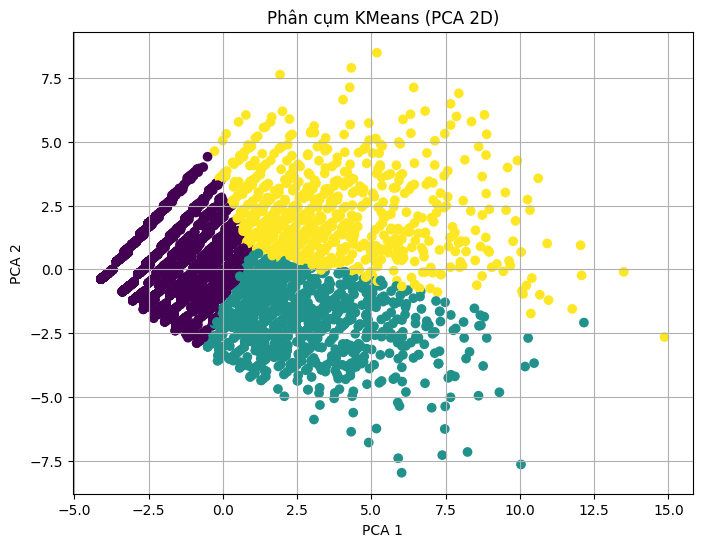

In [7]:
# --------------------- PCA 2D ---------------------
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')
plt.title("Phân cụm KMeans (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

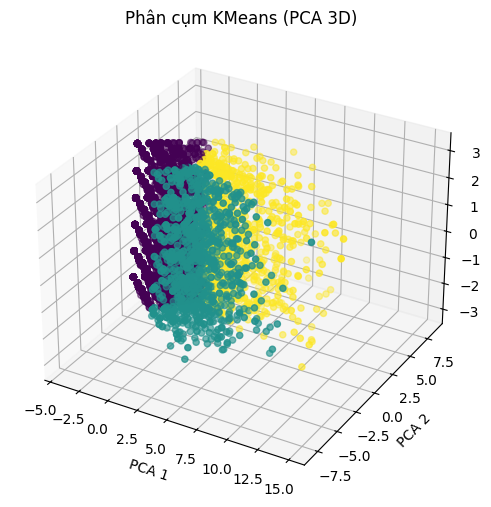

In [8]:
# --------------------- PCA 3D ---------------------
pca_3d = PCA(n_components=3, random_state=42)
X_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=labels, cmap='viridis')
ax.set_title("Phân cụm KMeans (PCA 3D)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.show()

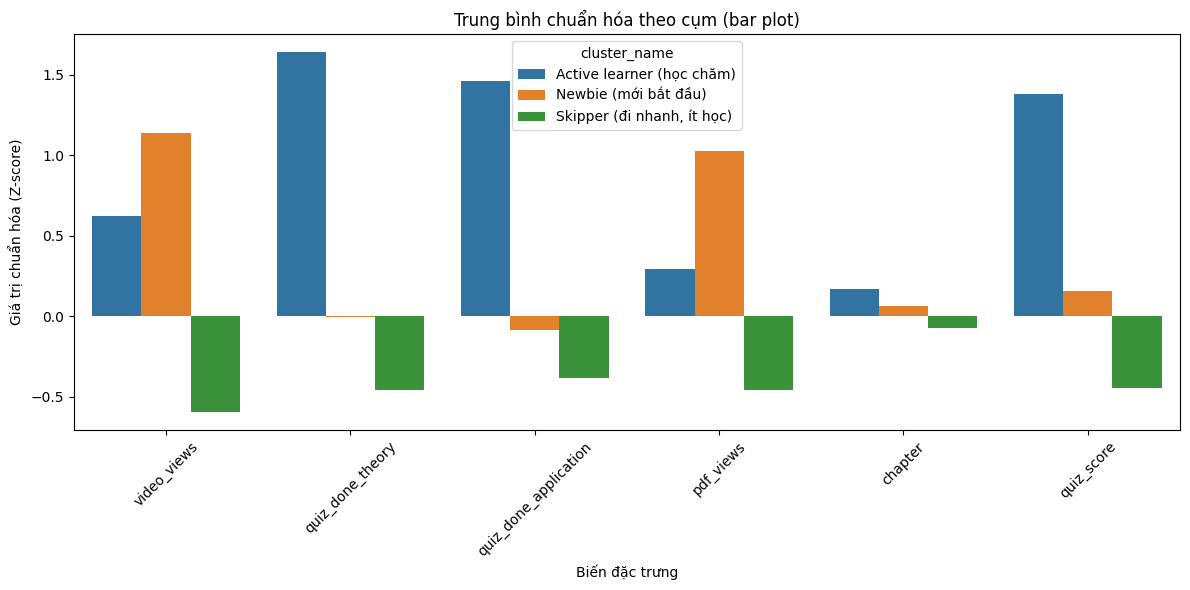

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_39737/2599167766.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_scaled, x="cluster_name", y=feat,


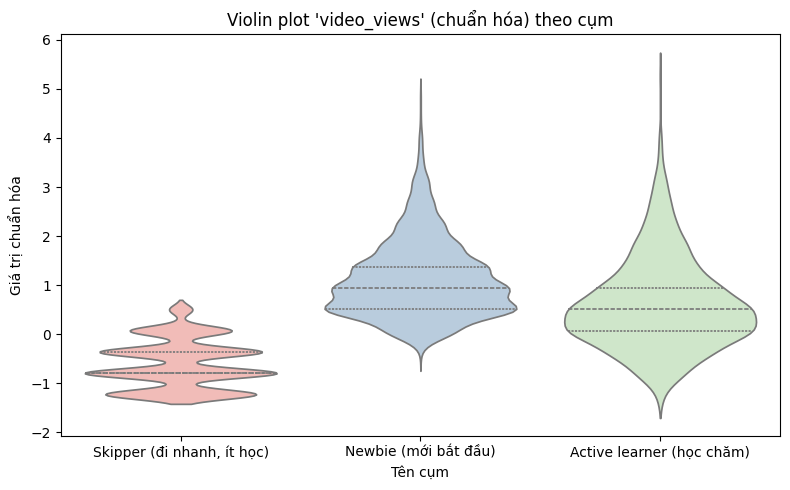

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_39737/2599167766.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_scaled, x="cluster_name", y=feat,


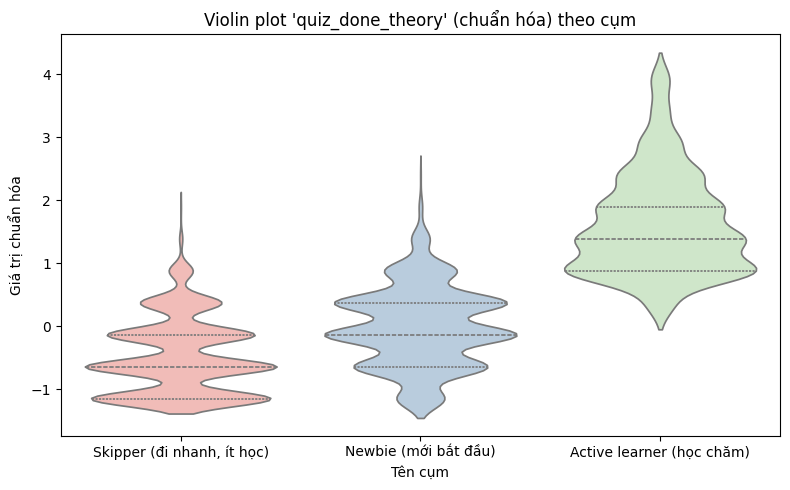

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_39737/2599167766.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_scaled, x="cluster_name", y=feat,


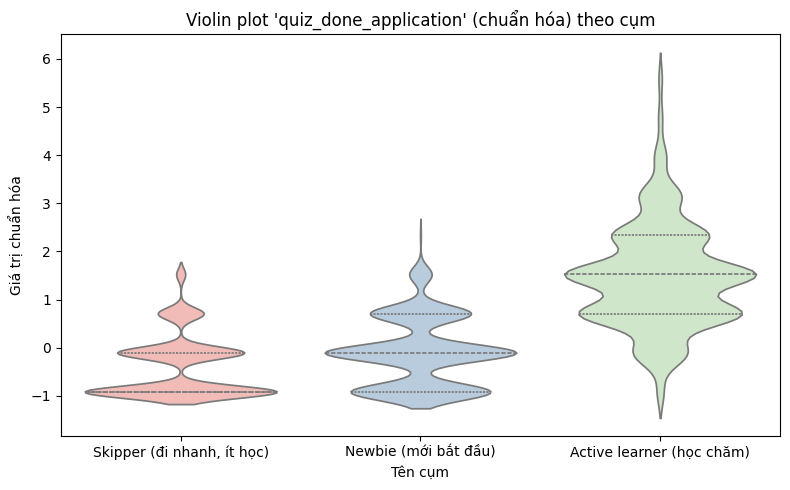

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_39737/2599167766.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_scaled, x="cluster_name", y=feat,


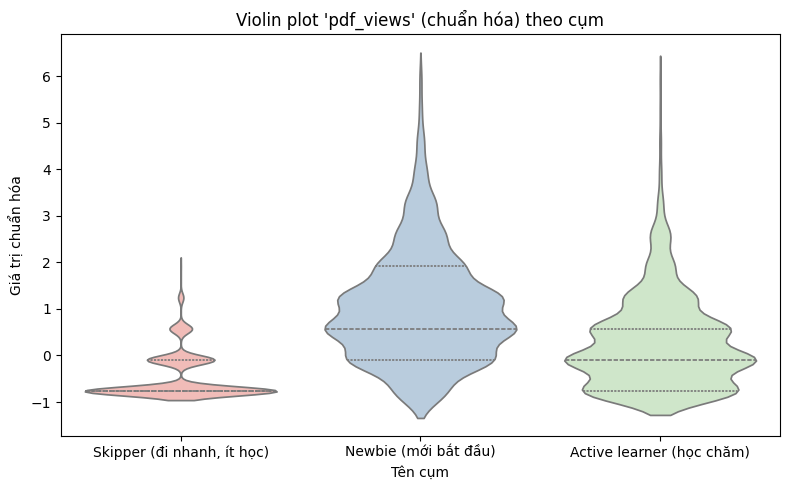

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_39737/2599167766.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_scaled, x="cluster_name", y=feat,


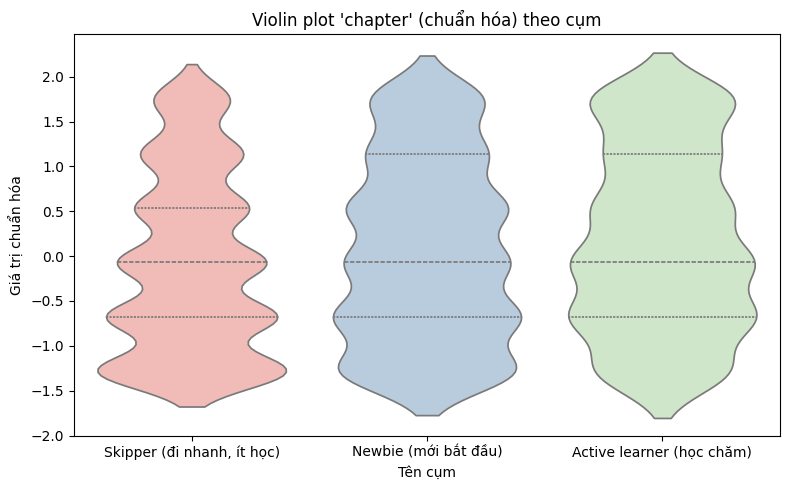

/var/folders/g4/mfpnrdbj2zj_69p2jw0y5nnc0000gn/T/ipykernel_39737/2599167766.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_scaled, x="cluster_name", y=feat,


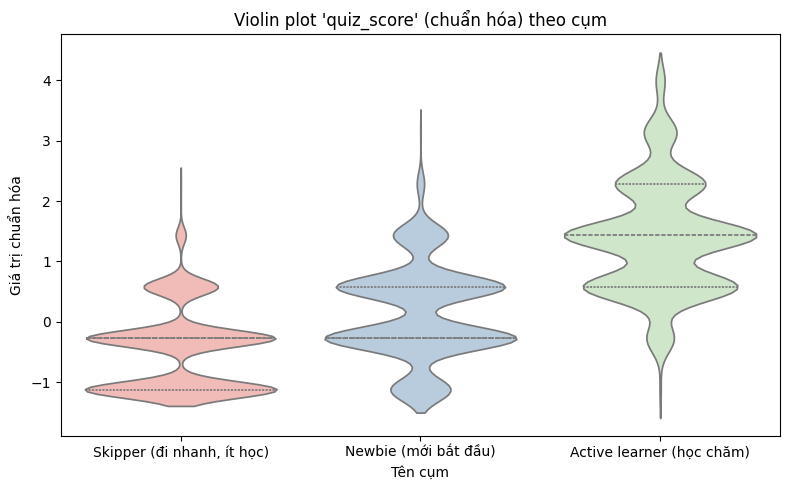

In [9]:
# ---------------- 5) Bar-plot & violin-plot ----------------
plot_dir = Path("output_plots")
plot_dir.mkdir(exist_ok=True)

features = ["video_views", "quiz_done_theory", "quiz_done_application",
            "pdf_views", "chapter", "quiz_score"]

# 5-a) Bar plot (chuẩn hóa)
scaler = StandardScaler()
df_scaled = df_full.copy()
df_scaled[features] = scaler.fit_transform(df_full[features])

bar_data = (df_scaled.groupby("cluster_name")[features]
            .mean().reset_index().melt(id_vars="cluster_name"))

plt.figure(figsize=(12, 6))
sns.barplot(data=bar_data, x="variable", y="value", hue="cluster_name")
plt.title("Trung bình chuẩn hóa theo cụm (bar plot)")
plt.ylabel("Giá trị chuẩn hóa (Z-score)")
plt.xlabel("Biến đặc trưng")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plot_dir / "bar_means_scaled.png", dpi=300)
plt.show()

# 5-b) Violin plot
for feat in features:
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=df_scaled, x="cluster_name", y=feat,
                   palette="Pastel1", inner="quartile")
    plt.title(f"Violin plot '{feat}' (chuẩn hóa) theo cụm")
    plt.xlabel("Tên cụm"); plt.ylabel("Giá trị chuẩn hóa")
    plt.tight_layout()
    plt.savefig(plot_dir / f"violin_{feat}.png", dpi=300)
    plt.show()

In [10]:
# --------------------- Trung bình từng cụm ---------------------
cluster_summary = df_full.groupby("cluster_name").mean(numeric_only=True).round(2)
print("\n📊 Trung bình các đặc trưng theo từng cụm:")
print(cluster_summary)


📊 Trung bình các đặc trưng theo từng cụm:
                            video_views  quiz_done_theory  \
cluster_name                                                
Active learner (học chăm)          4.27              5.49   
Newbie (mới bắt đầu)               5.47              2.25   
Skipper (đi nhanh, ít học)         1.45              1.35   

                            quiz_done_application  pdf_views  chapter  \
cluster_name                                                            
Active learner (học chăm)                    2.93       1.58     3.39   
Newbie (mới bắt đầu)                         1.02       2.67     3.22   
Skipper (đi nhanh, ít học)                   0.66       0.45     3.00   

                            quiz_score  cluster  
cluster_name                                     
Active learner (học chăm)         2.94      2.0  
Newbie (mới bắt đầu)              1.50      1.0  
Skipper (đi nhanh, ít học)        0.79      0.0  


In [11]:
# --------------------- Lưu kết quả ---------------------
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

df_full.to_csv(output_dir / "clustered_data.csv", index=False)
cluster_summary.to_csv(output_dir / "cluster_summary.csv")

print("\n✅ Dữ liệu đã lưu vào thư mục 'output/'")


✅ Dữ liệu đã lưu vào thư mục 'output/'
